# NFL Big Data Bowl 2022

**Authors**: Chaya Norton, Elizabeth Campolongo, Ranthony Edmonds, Kenneth Howe

## I. Getting the Initial Data

In [2]:
import pandas as pd

### 1. Importing the NFL Big Data Bowl Datasets

To start, we'll need data concerning the plays, games, and players.

In [3]:
plays = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/plays.csv')
games = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/games.csv')
players = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/players.csv')

To reduce the amount of memory occupied by the very large tracking dataset, we have separated the tracking data according to each play type.

In [4]:
fg_tracking_2018 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2018.csv')
fg_tracking_2019 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2019.csv')
fg_tracking_2020 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2020.csv')

In [5]:
ep_tracking_2018 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/ep_tracking_2018.csv')
ep_tracking_2019 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/ep_tracking_2019.csv')
ep_tracking_2020 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/ep_tracking_2020.csv')

## II. Performing Initial Cleaning/Pre-Processing

To perform our analyses of field goal and extra point plays, we will need to prepare datasets containing the data regarding each play type. Before we assemble these datasets, it will be useful to perform some initial cleaning and pre-processing on the raw data that we just imported.

### 1. Pre-Processing Tracking Data

In [6]:
from pipeline.preprocessing import preprocess_tracking, preprocess_football_track

In [7]:
# Pre-process field goal data
fg_tracking_2018, fg_tracking_2019, fg_tracking_2020 = preprocess_tracking(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, plays, 'Field Goal')
fg_tracking_ball = preprocess_football_track(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020)

# Pre-process extra point data
ep_tracking_2018, ep_tracking_2019, ep_tracking_2020 = preprocess_tracking(ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, plays, 'Extra Point')
ep_tracking_ball = preprocess_football_track(ep_tracking_2018, ep_tracking_2019, ep_tracking_2020)


### 2. Pre-Processing Play Data

In [8]:
from pipeline.preprocessing import preprocess_play
from pipeline.preprocessing import drop_by_index_difference

In [9]:
play_df = preprocess_play(plays)

To eliminate plays with low-quality tracking data, we employ the following pre-processing function. In short, the function compares the labelled occasion of the given event with the moment that the event "actually" occurs (captured by the moment at which the ball reaches its maximum velocity). We discard any plays in which these two moments are substantially disparate.

In [10]:
fg_play_df = drop_by_index_difference(play_df, fg_tracking_ball, 'field_goal_attempt')
ep_play_df = drop_by_index_difference(play_df, ep_tracking_ball, 'extra_point_attempt')

### 3. Pre-Process Players Data

In [11]:
from pipeline.preprocessing import preprocess_players

In [12]:
players_df = preprocess_players(players)

## III. Constructing Play Type DataFrames

As mentioned above, we want to separate our data according to play type to perform separate analyses on each. Here we assemble datasets containing all of the relevant data for each play type (field goals and extra points).

In [13]:
from pipeline.dataset_builders import make_field_goal, make_extra_point

In [14]:
field_goal_df = make_field_goal(fg_play_df, players_df, fg_tracking_ball)
extra_point_df = make_extra_point(ep_play_df, players_df, ep_tracking_ball)

/home/kenneth/Documents/NFL/NFL_BDB_2022/pipeline/dataset_builders.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
/home/kenneth/Documents/NFL/NFL_BDB_2022/pipeline/dataset_builders.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)
/home/kenneth/Documents/NFL/NFL_BDB_2022/pipeline/dataset_builders.py:

In [15]:
play_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'specialTeamsPlayType', 'specialTeamsResult',
       'kickerId', 'returnerId', 'kickBlockerId', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers',
       'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'kickLength', 'kickReturnYardage', 'playResult',
       'absoluteYardlineNumber', 'gameClockSeconds'],
      dtype='object')

## IV. Feature Engineering

In order to improve the results of our clustering and to add meaningful insights to our analyses, we generate a handful of meaningful engineered features:

    - `endzone_y`: The location of the kicked ball at the moment in which it crosses the 0 or 120 yard line.
    - `expected_endzone_y`: The expected location of the kicked ball at the moment in which it crosses the 0 or 120 yard line, extrapolated using a straight-line trajectory from the initial moments after the kick.
    - `endzone_y_off_center`: The distance between the `endzone_y` position and the centerline of the field goal posts.
    - `endzone_y_error` - The absolute difference between `expected_endzone_y` and `endzone_y` (i.e. intended vs. actual).
    - `kicker_core_distance_1`: The distance between the kicker and the closest player on the opposing team.
    - `kicker_core_distance_3`: The distance between the kicker and the third-closest player on the opposing team. (This serves as an approximation of the density of defensive players around the kicker.)

In [16]:
from pipeline.feature_engineering import endzone_y_pos, endzone_y_expected, endzone_y_off_center, endzone_y_error, kicker_core_dist

### 1. Endzone Y-Position

In [17]:
field_goal_df = endzone_y_pos(field_goal_df, fg_tracking_ball)
extra_point_df = endzone_y_pos(extra_point_df, ep_tracking_ball)

### 2. Expected Endzone Y-Position

In [18]:
field_goal_df = endzone_y_expected(field_goal_df, fg_tracking_ball, 'field_goal_attempt')
extra_point_df = endzone_y_expected(extra_point_df, ep_tracking_ball, 'extra_point_attempt')

### 3. Endzone Y-Position Off-Center

In [19]:
field_goal_df = endzone_y_off_center(field_goal_df)
extra_point_df = endzone_y_off_center(extra_point_df)

### 4. Endzone Y-Position Error

In [20]:
field_goal_df = endzone_y_error(field_goal_df)
extra_point_df = endzone_y_error(extra_point_df)

### 5. Kicker Core Distances

In [21]:
# Kicker core distance 1
field_goal_df = kicker_core_dist(field_goal_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=1)
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=1)

/home/kenneth/Documents/NFL/NFL_BDB_2022/pipeline/feature_engineering.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])


In [22]:
# Kicker core distance 3
field_goal_df = kicker_core_dist(field_goal_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=3)
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=3)

## V. Final Pre-Processing Steps

In [23]:
from pipeline.preprocessing import preprocess_fg, preprocess_ep

In [24]:
field_goal_X, field_goal_df = preprocess_fg(field_goal_df, encode_categorical=False)
extra_point_X, extra_point_df = preprocess_ep(extra_point_df, encode_categorical=False)

## VI. Clustering with UMAP and HDBSCAN

Behind the scenes, our clustering is a process that occurs in two steps.

First, UMAP is used to embed our data into a "natural" lower-dimensional representation. To accomplish this with mixed data types, two separate embeddings are created for our numeric data and our categorical data respectively. These two embeddings are then combined to produce a final three-dimensional embedding of our data.

Once the data is embedded in this lower dimensional space, HDBSCAN is then used to detect the clusters which are intrinsically present in the data.

To accomplish both of these steps using a single, easy-to-use model, we make use of the `Amazon-DenseClus` package.

In [25]:
from denseclus import DenseClus

### 1. Initialize Model

In [26]:
field_goal_clf = DenseClus(umap_combine_method='intersection_union_mapper')
extra_point_clf = DenseClus(umap_combine_method='intersection_union_mapper')

### 2. Fit the Model

In [27]:
field_goal_clf.fit(field_goal_df)
extra_point_clf.fit(extra_point_df)

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


### 3. Add Cluster IDs to DataFrame

In [28]:
field_goal_df['cluster_id'] = field_goal_clf.score()
extra_point_df['cluster_id'] = extra_point_clf.score()

### 4. Create Cluster Dictionaries

In [29]:
fg_cluster_dict = {id: field_goal_df[field_goal_df['cluster_id']==id] for id in field_goal_df['cluster_id'].unique()}
ep_cluster_dict = {id: extra_point_df[extra_point_df['cluster_id']==id] for id in extra_point_df['cluster_id'].unique()}

## VII. Investigate Model Results

In [30]:
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


### 1. Clustering Statistics

In [31]:
fg_num_clusters = field_goal_df['cluster_id'].max() + 1
ep_num_clusters = extra_point_df['cluster_id'].max() + 1

In [32]:
fg_num_outliers = field_goal_df['cluster_id'].value_counts()[-1]
ep_num_outliers = extra_point_df['cluster_id'].value_counts()[-1]

fg_percent_outliers = 100 * fg_num_outliers / len(field_goal_df['cluster_id'])
ep_percent_outliers = 100 * ep_num_outliers / len(extra_point_df['cluster_id'])

In [33]:
print('Field Goal Modeling Results:\n============================')
print(f'Number of Clusters: {fg_num_clusters}')
print(f'Number of Outliers: {fg_num_outliers} ({fg_percent_outliers:.2f}%)')
print(f'Special Teams Counts:\n{field_goal_df.groupby("cluster_id")["specialTeamsResult"].value_counts()}')

Field Goal Modeling Results:
Number of Clusters: 4
Number of Outliers: 77 (3.24%)
Special Teams Counts:
cluster_id  specialTeamsResult  
-1          Kick Attempt Good         42
            Kick Attempt No Good      35
 0          Kick Attempt No Good     196
 1          Kick Attempt No Good     117
 2          Kick Attempt Good       1843
 3          Kick Attempt Good        144
Name: specialTeamsResult, dtype: int64


In [34]:
print('Extra Point Modeling Results:\n=============================')
print(f'Number of Clusters: {ep_num_clusters}')
print(f'Number of Outliers: {ep_num_outliers} ({ep_percent_outliers:.2f}%)')
print(f'Special Teams Counts:\n{extra_point_df.groupby("cluster_id")["specialTeamsResult"].value_counts()}')

Extra Point Modeling Results:
Number of Clusters: 2
Number of Outliers: 140 (4.37%)
Special Teams Counts:
cluster_id  specialTeamsResult  
-1          Kick Attempt Good        107
            Kick Attempt No Good      33
 0          Kick Attempt No Good     155
            Kick Attempt Good          6
 1          Kick Attempt Good       2904
Name: specialTeamsResult, dtype: int64


### 2. Visualize Embeddings

#### Field Goal Numerical Embedding

In [35]:
fg_numerical_embedding = field_goal_clf.numerical_umap_.fit_transform(field_goal_X.drop(columns=['specialTeamsResult', 'penaltyCodes']))
fg_numerical_df = pd.DataFrame(fg_numerical_embedding, columns=['x','y','z'])
fg_numerical_df['cluster_id'] = field_goal_clf.score()
fg_groups = fg_numerical_df.groupby('cluster_id')

In [42]:
fig = px.scatter_3d(fg_numerical_df, x='x', y='y', z='z', color=fg_numerical_df['cluster_id'].astype(str))
fig.update_traces(
    marker = dict(size=3)
)
#fig.write_html('field_goal_embedding.html')

#### Extra Point Numerical Embedding

In [37]:
ep_numerical_embedding = extra_point_clf.numerical_umap_.fit_transform(extra_point_X.drop(columns=['specialTeamsResult', 'penaltyCodes']))
ep_numerical_df = pd.DataFrame(ep_numerical_embedding, columns=['x','y','z'])
ep_numerical_df['cluster_id'] = extra_point_clf.score()

In [43]:
fig = px.scatter_3d(ep_numerical_df, x='x', y='y', z='z', color=ep_numerical_df['cluster_id'].astype(str))
fig.update_traces(
    marker = dict(size=3)
)
#fig.write_html('extra_point_embedding.html')

### 3. Investigate Cluster Contents

In [46]:
fg_cluster_dict.keys()

dict_keys([2, 1, 3, 0, -1])

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

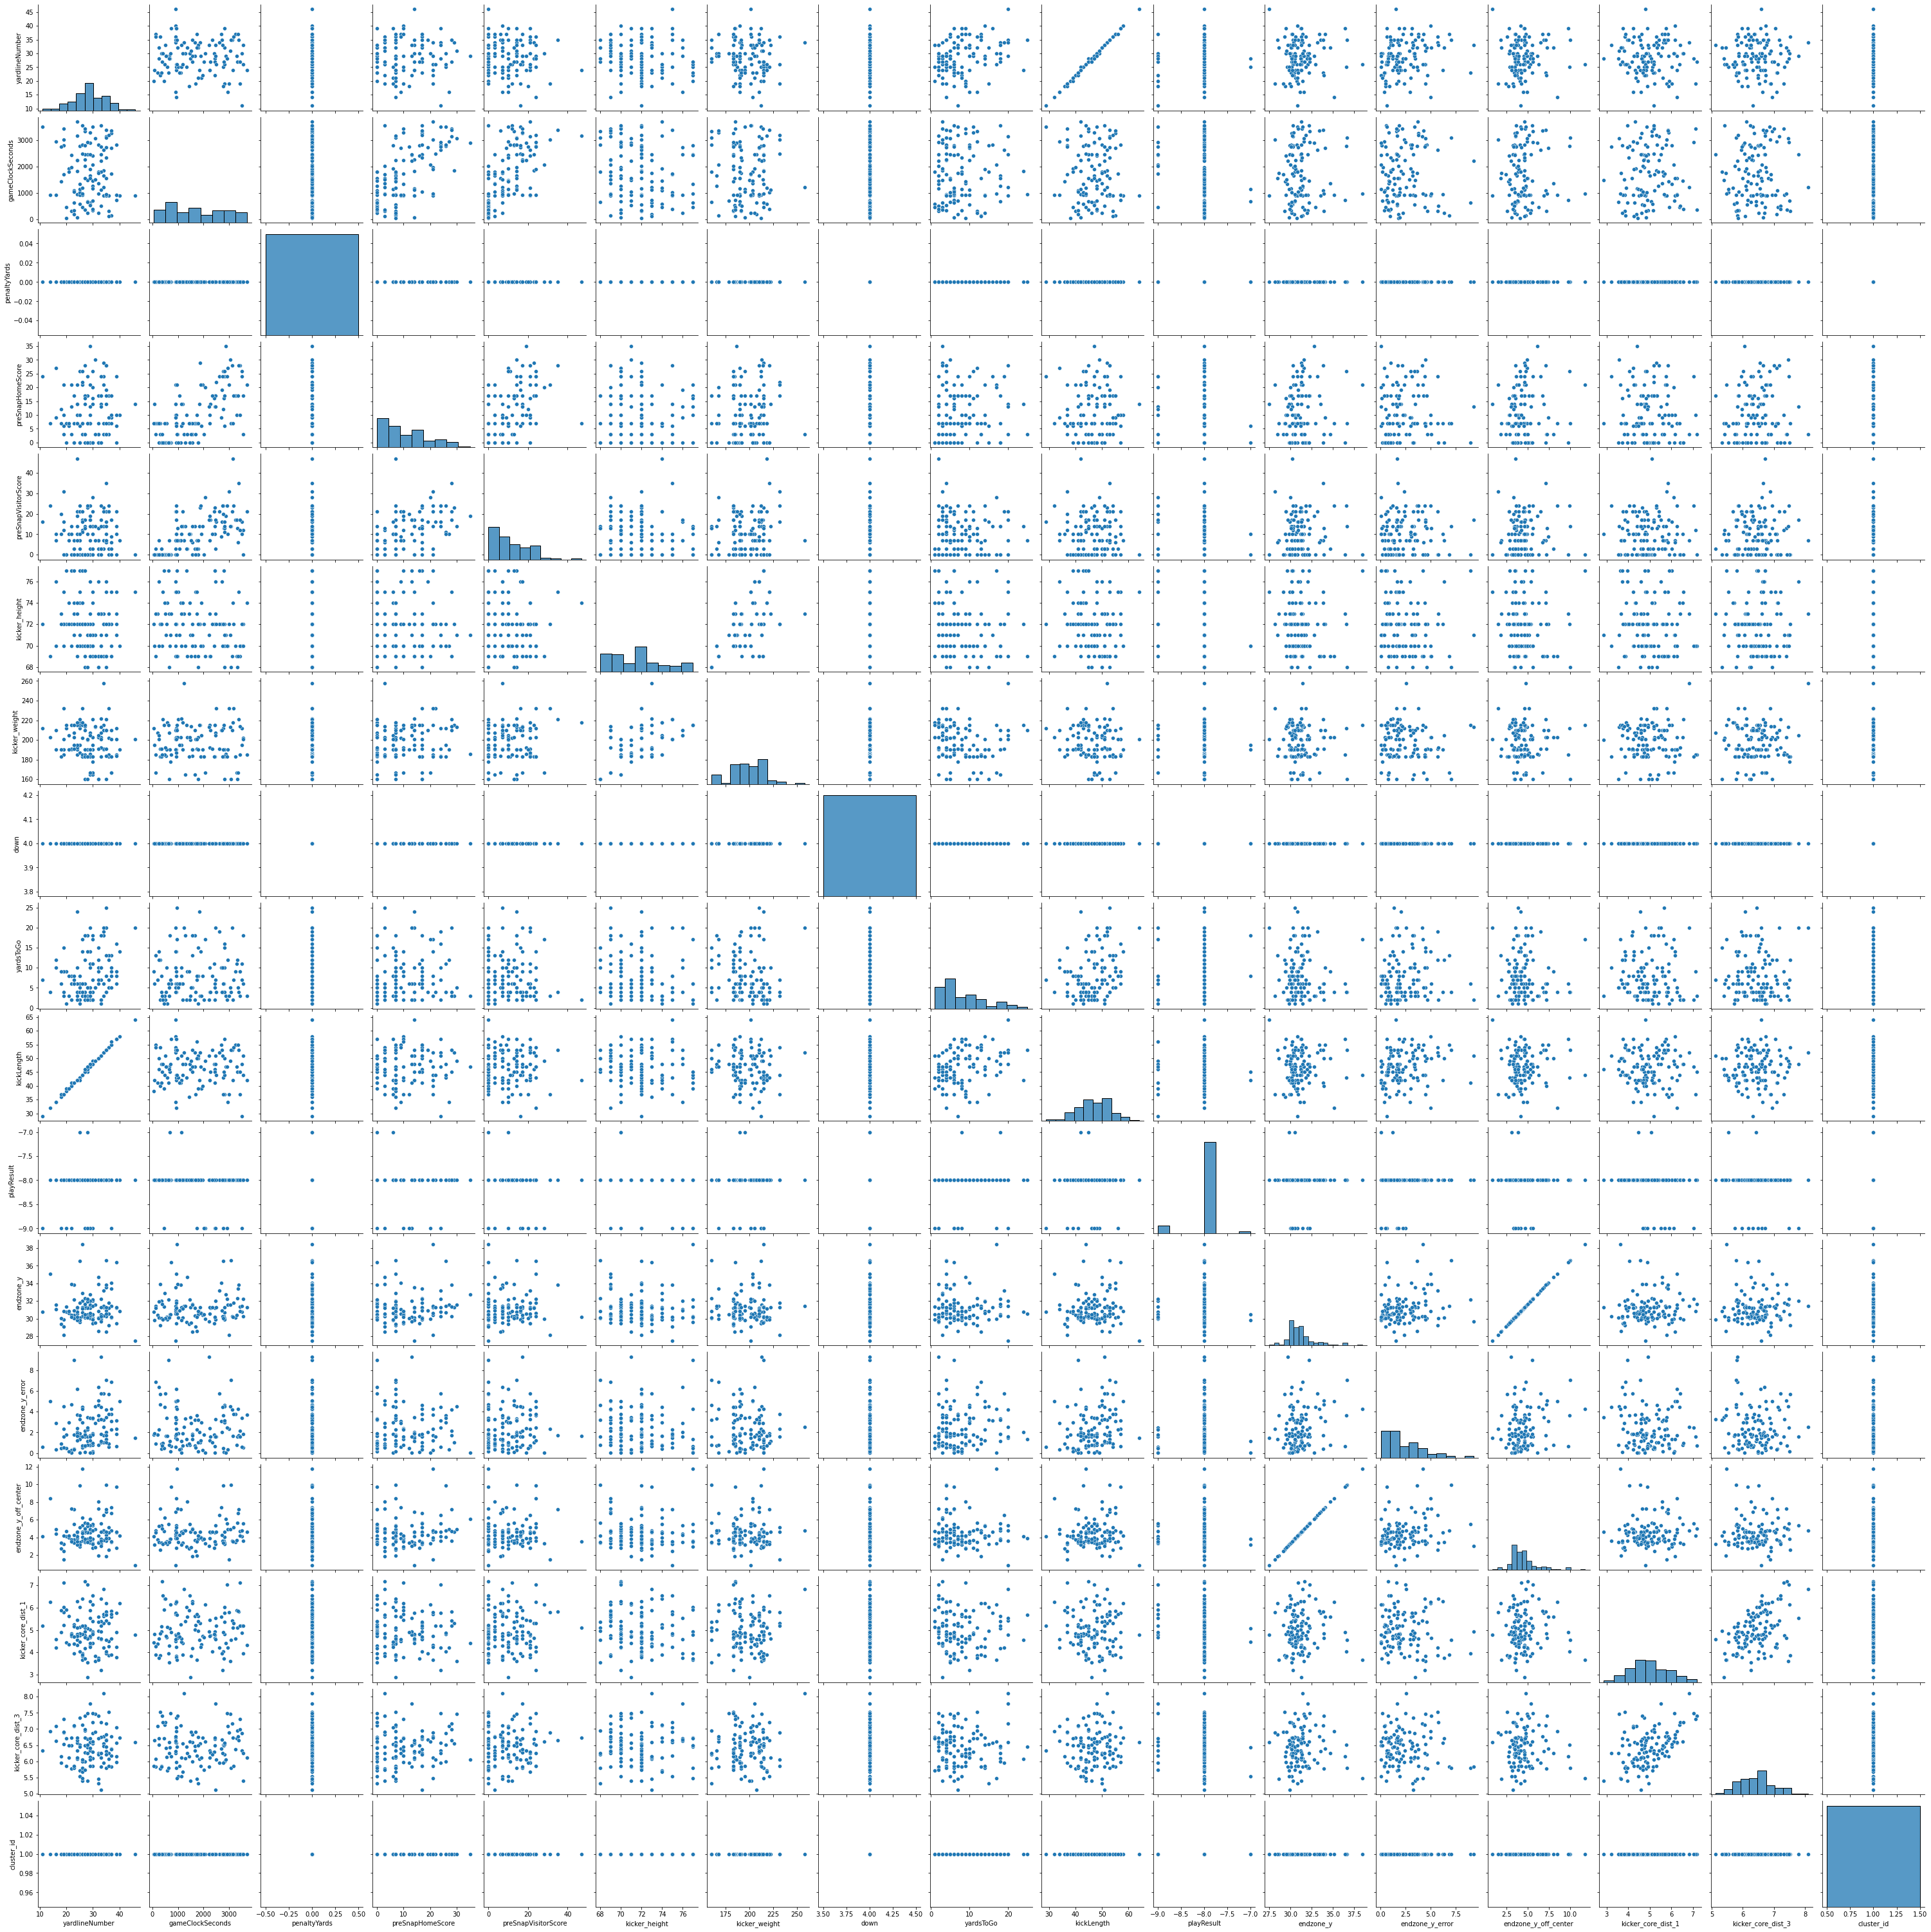

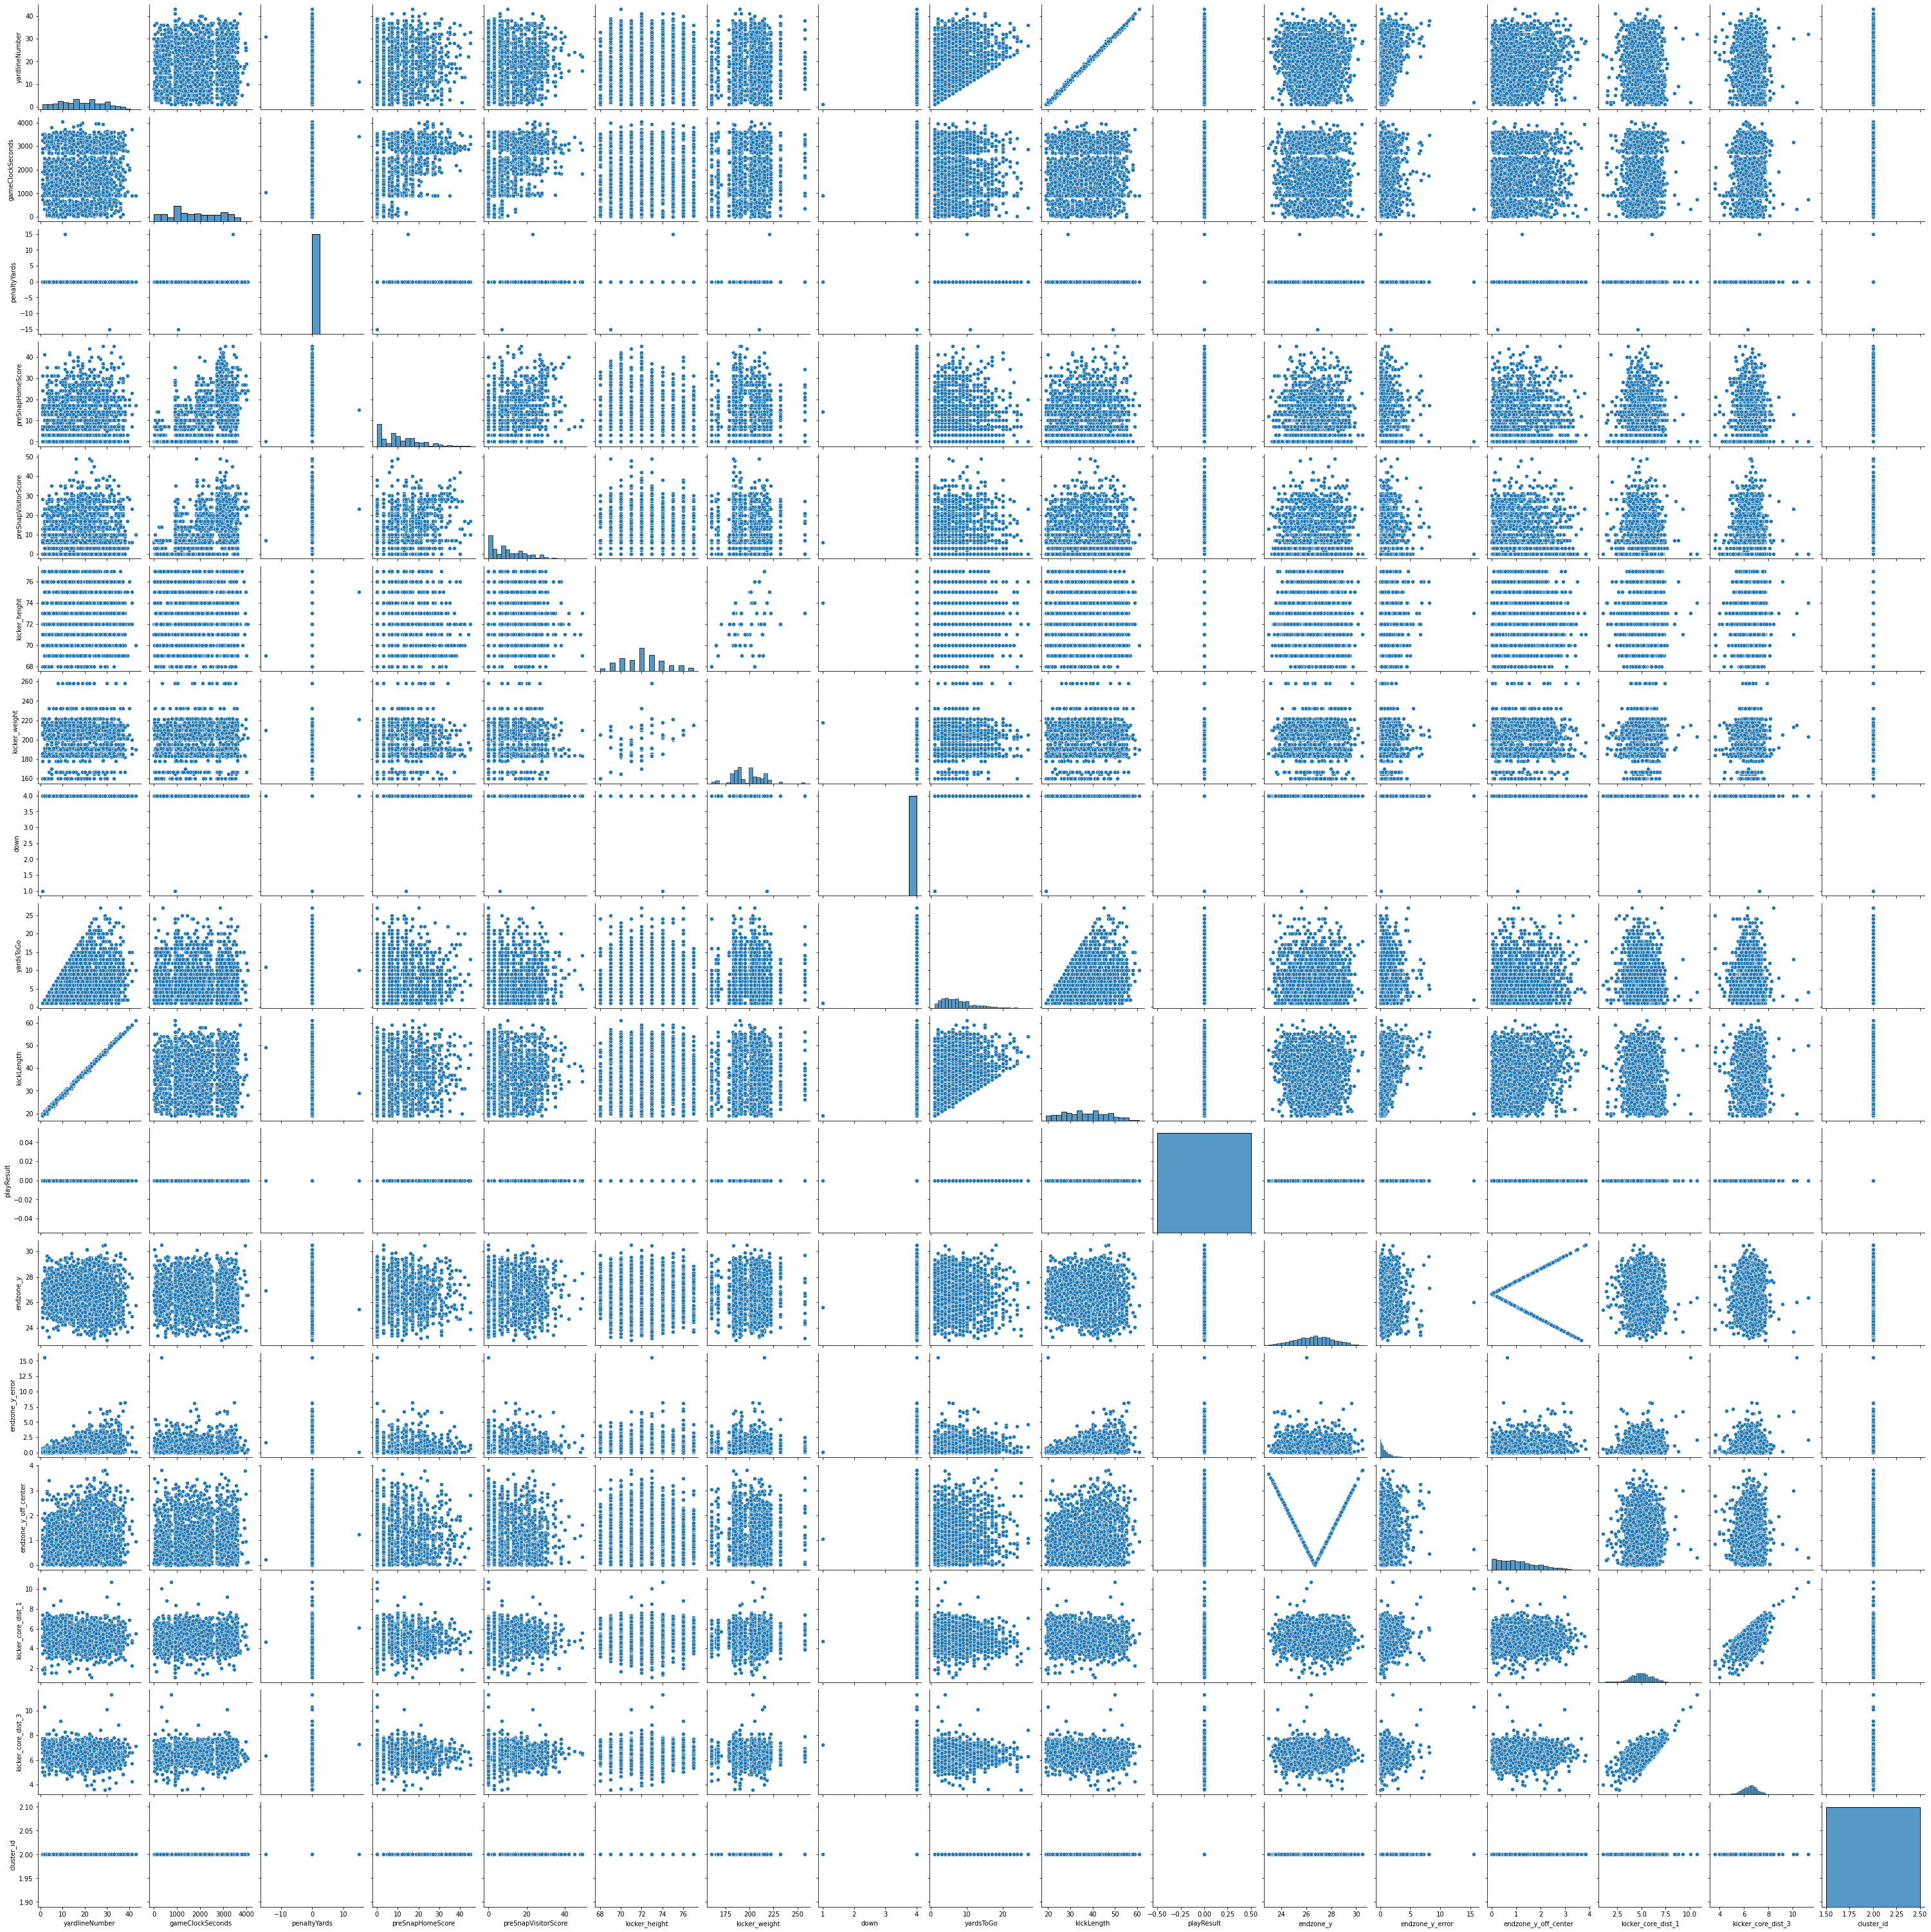

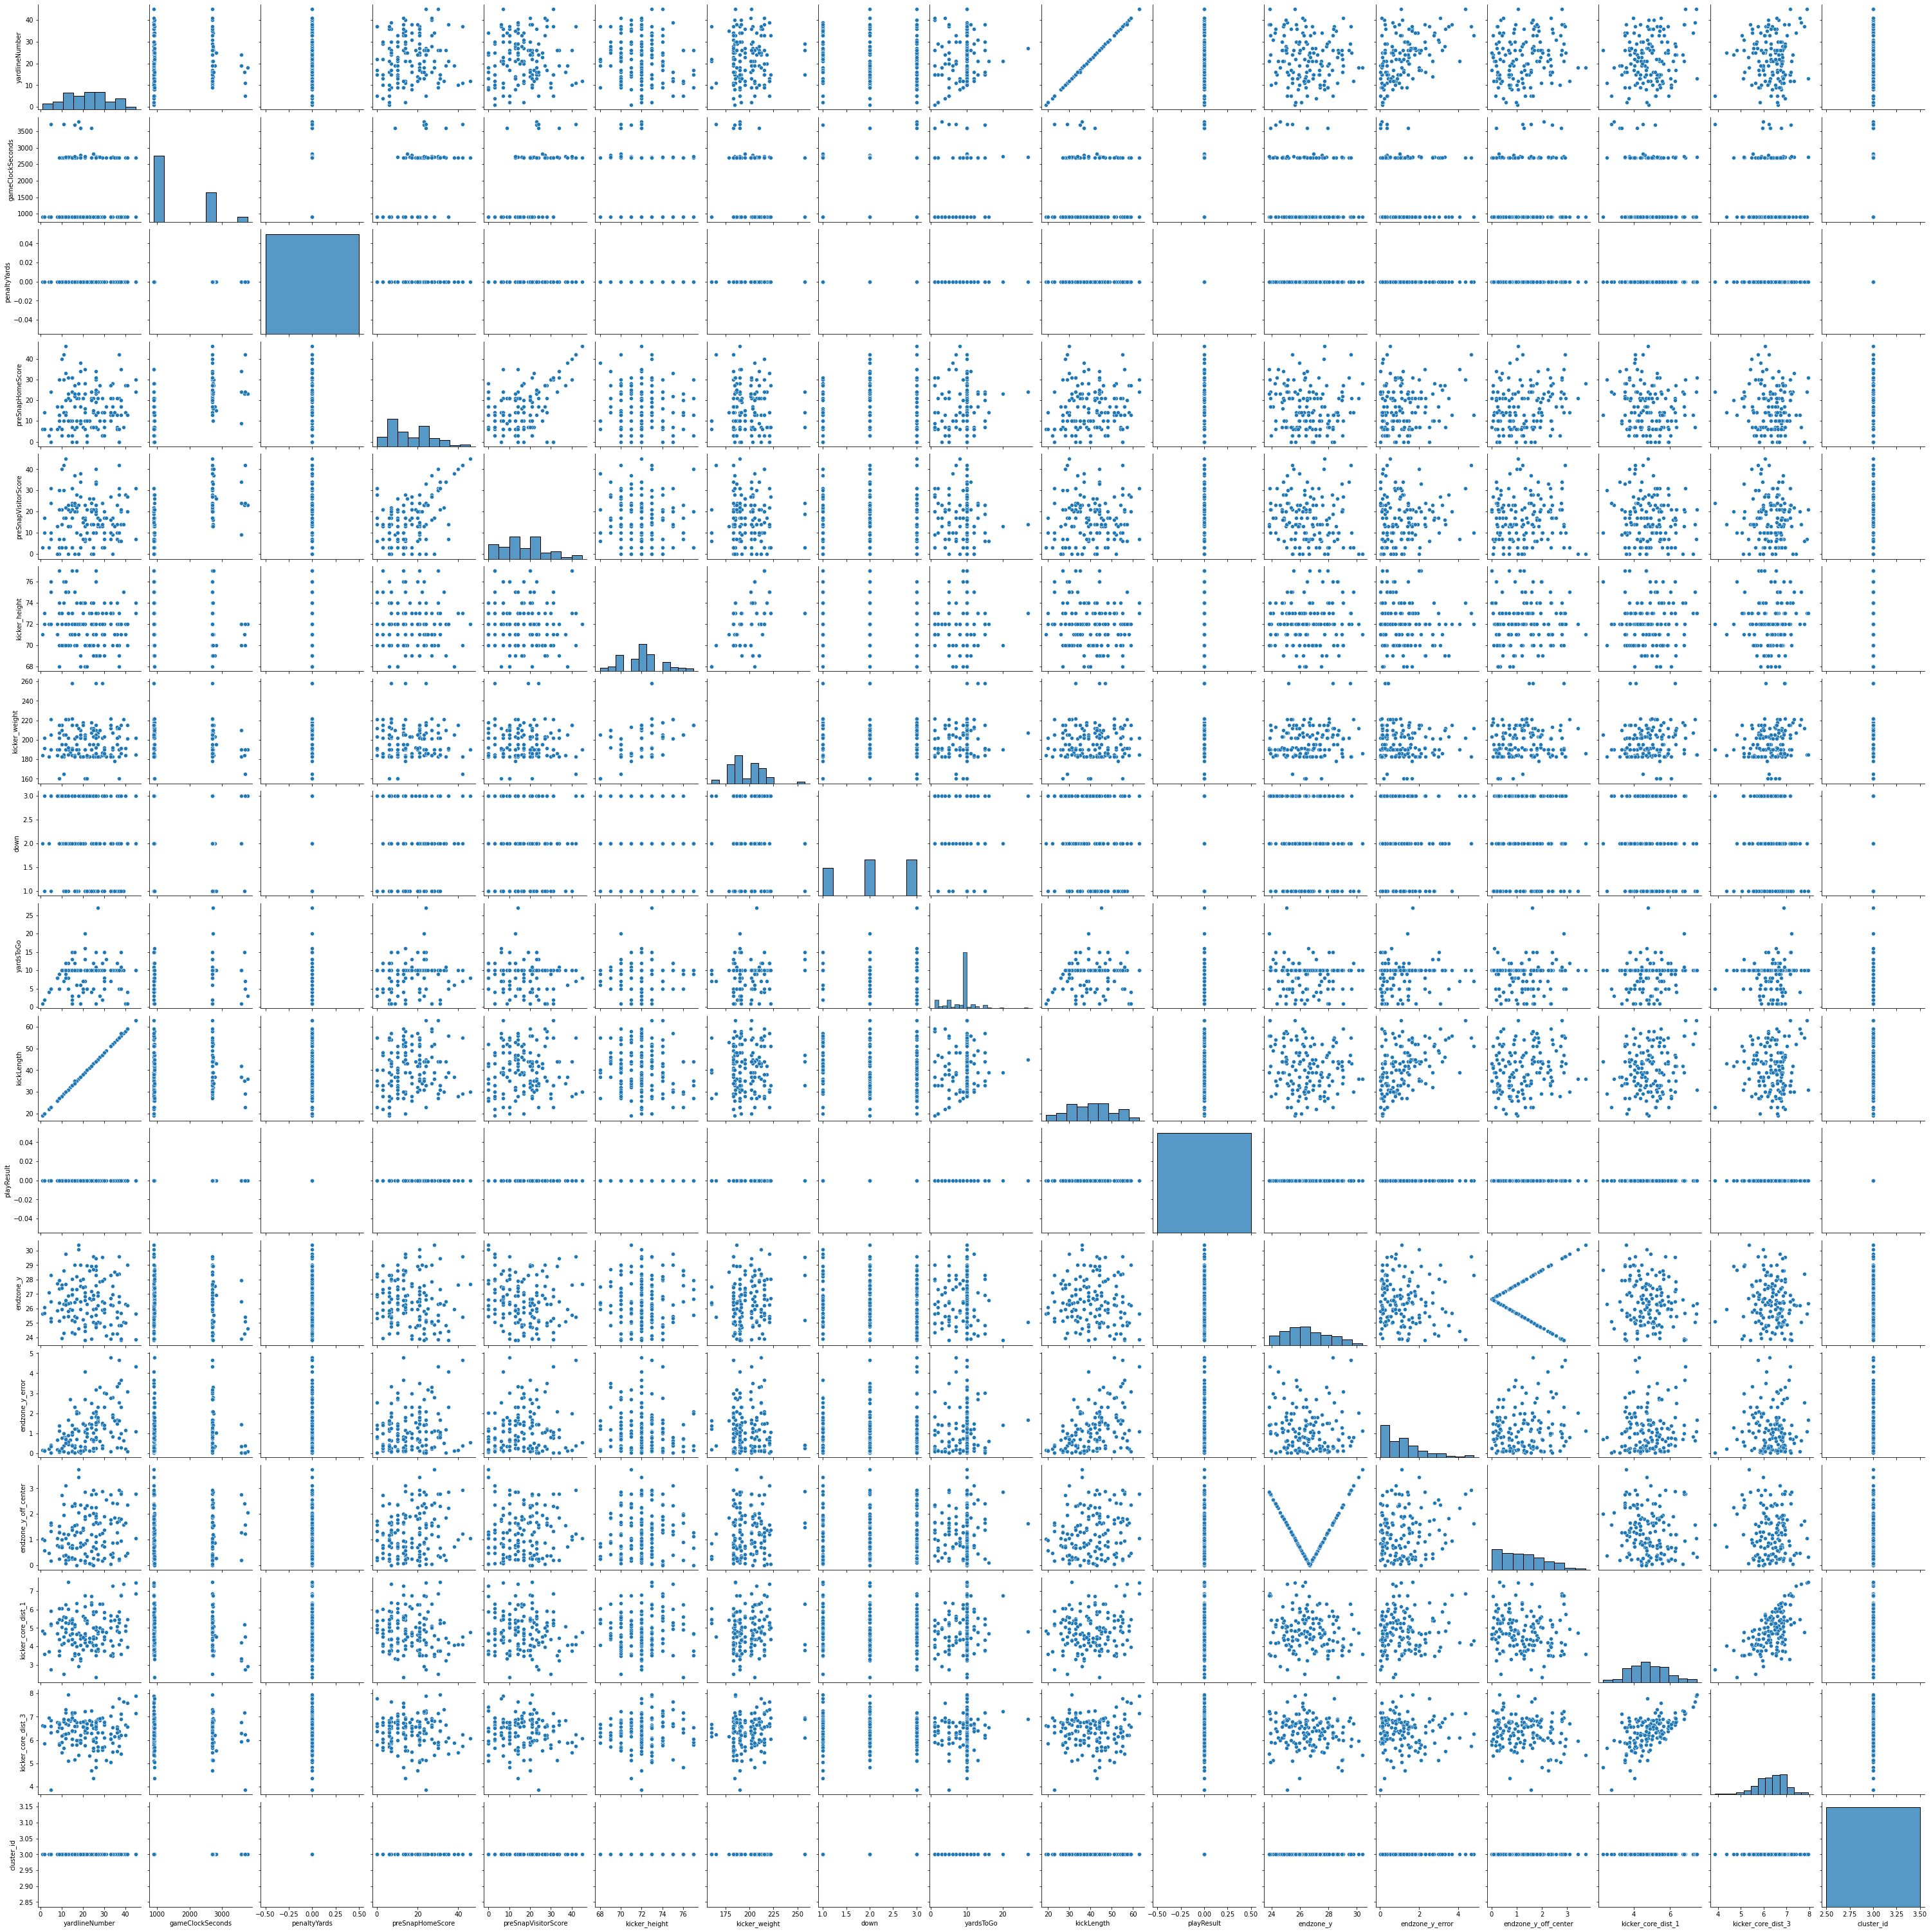

<Figure size 432x288 with 0 Axes>

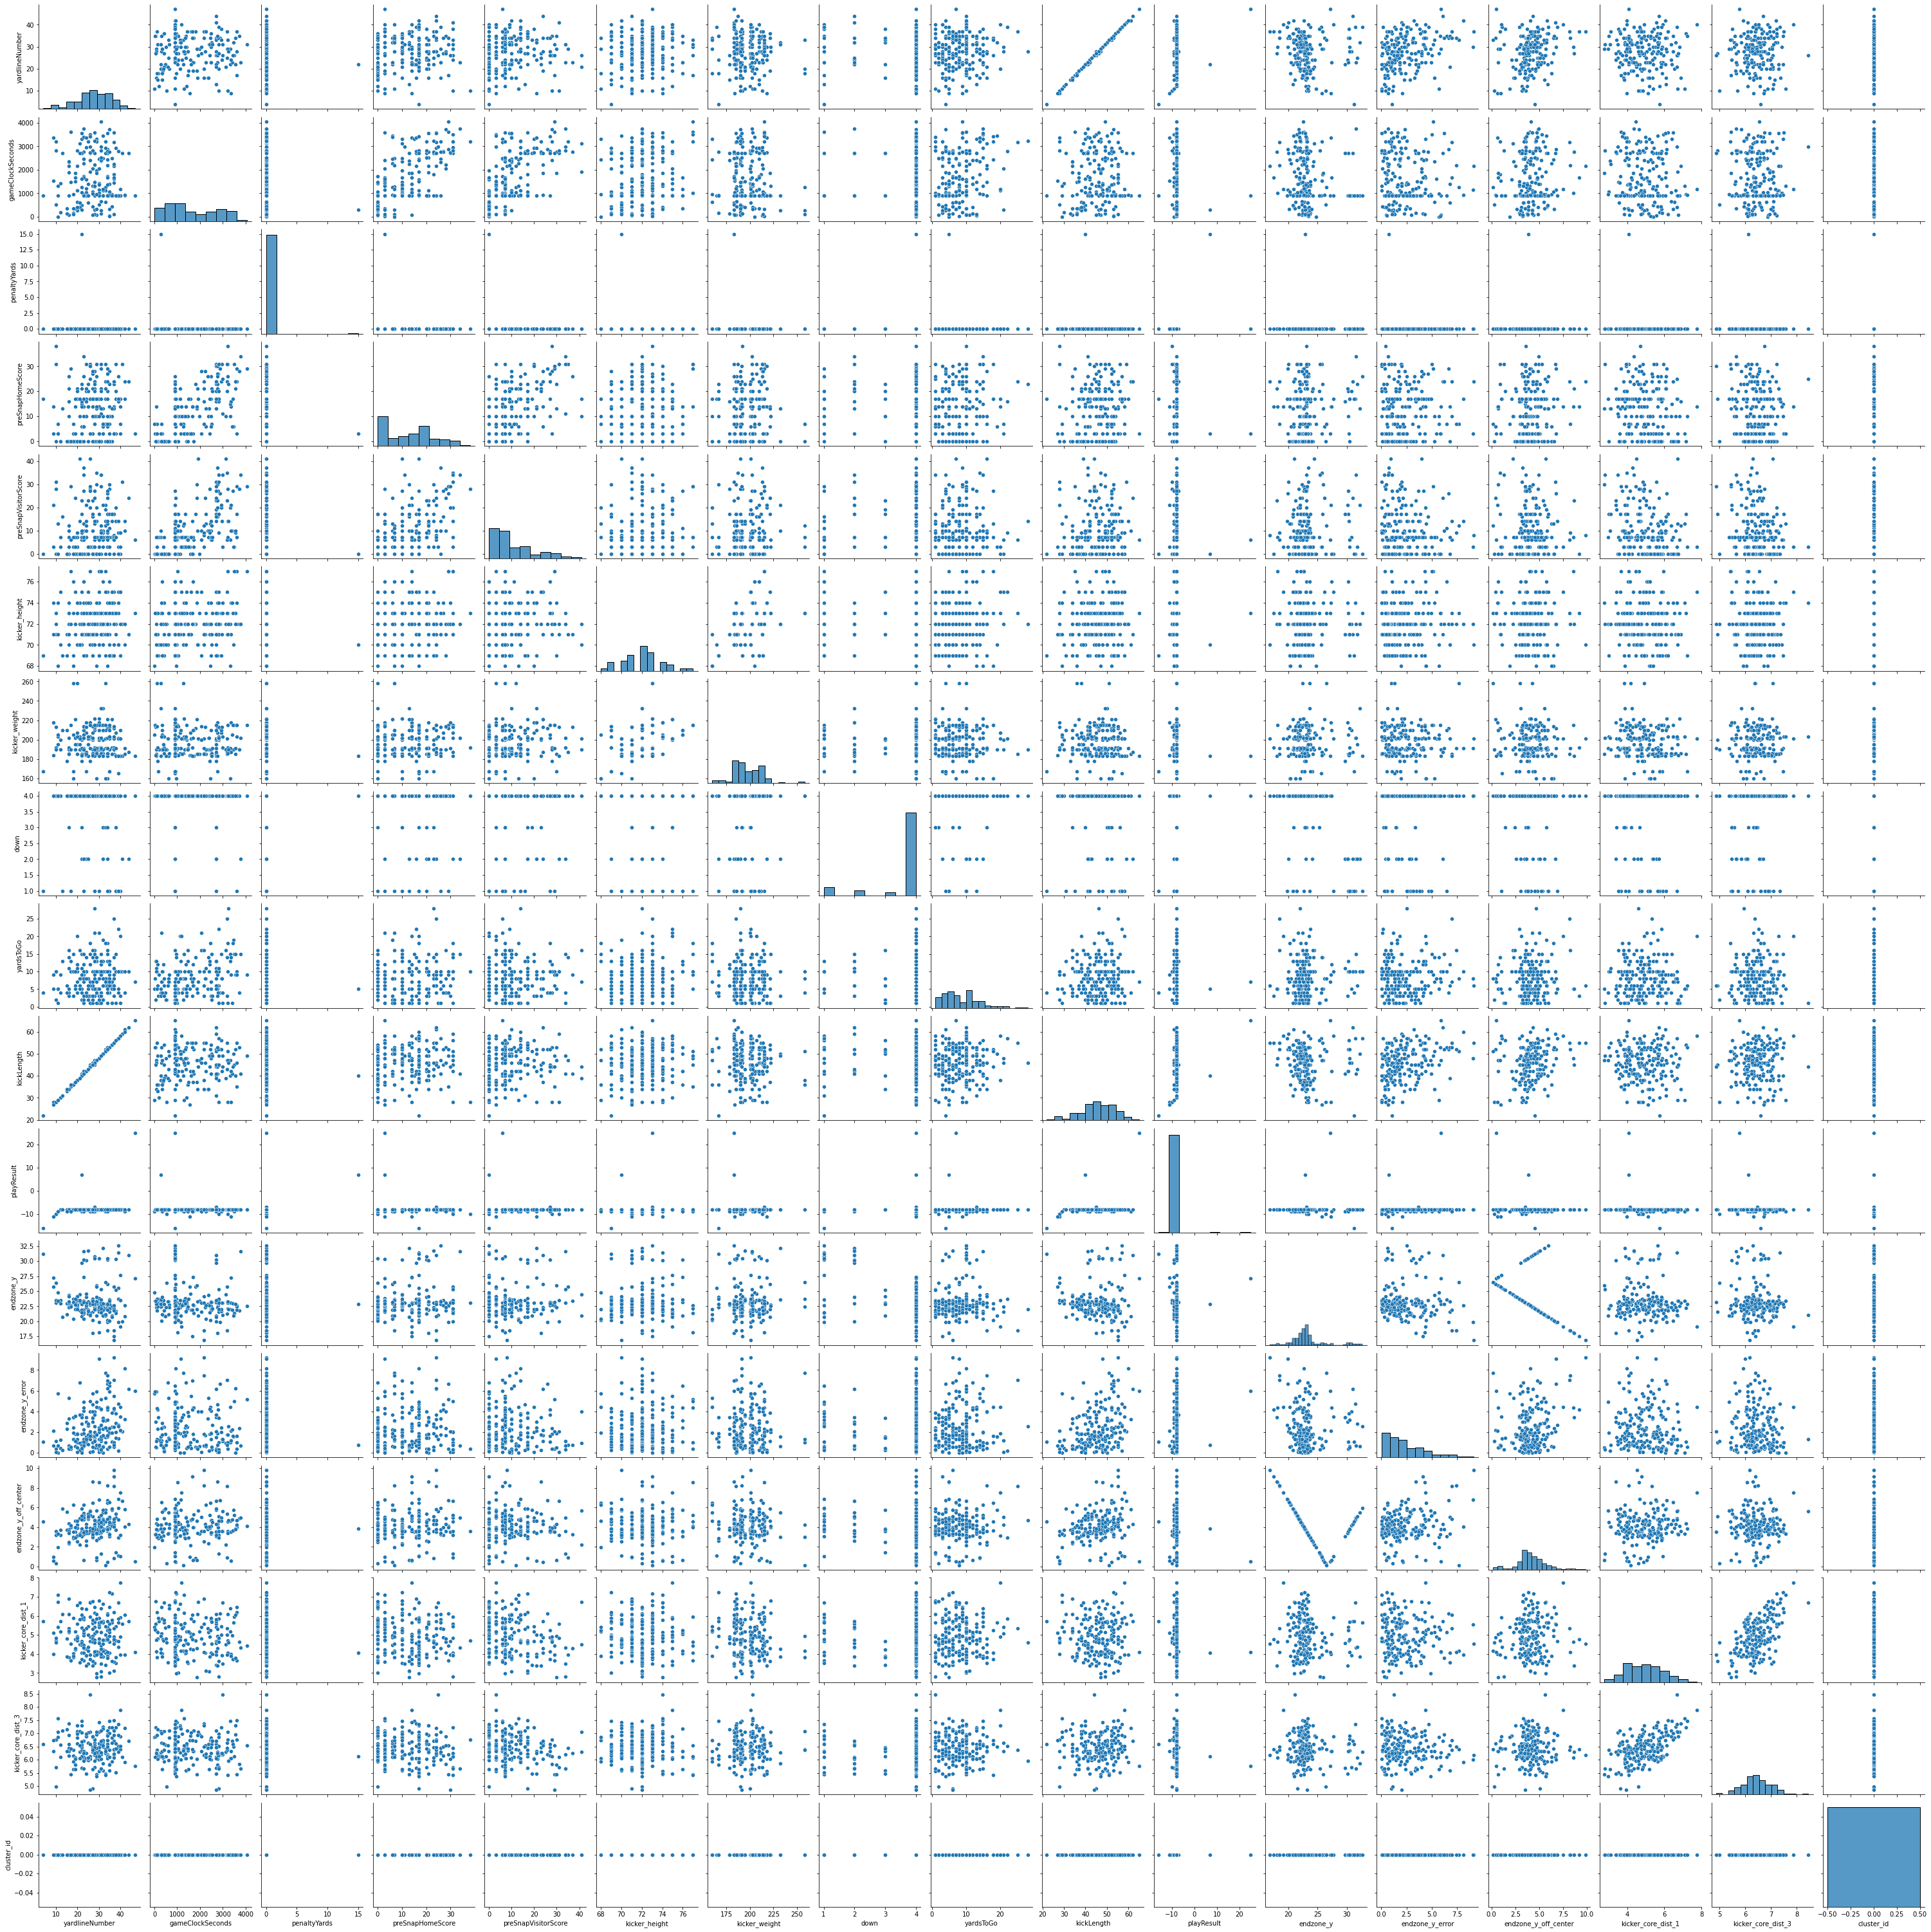

<Figure size 432x288 with 0 Axes>

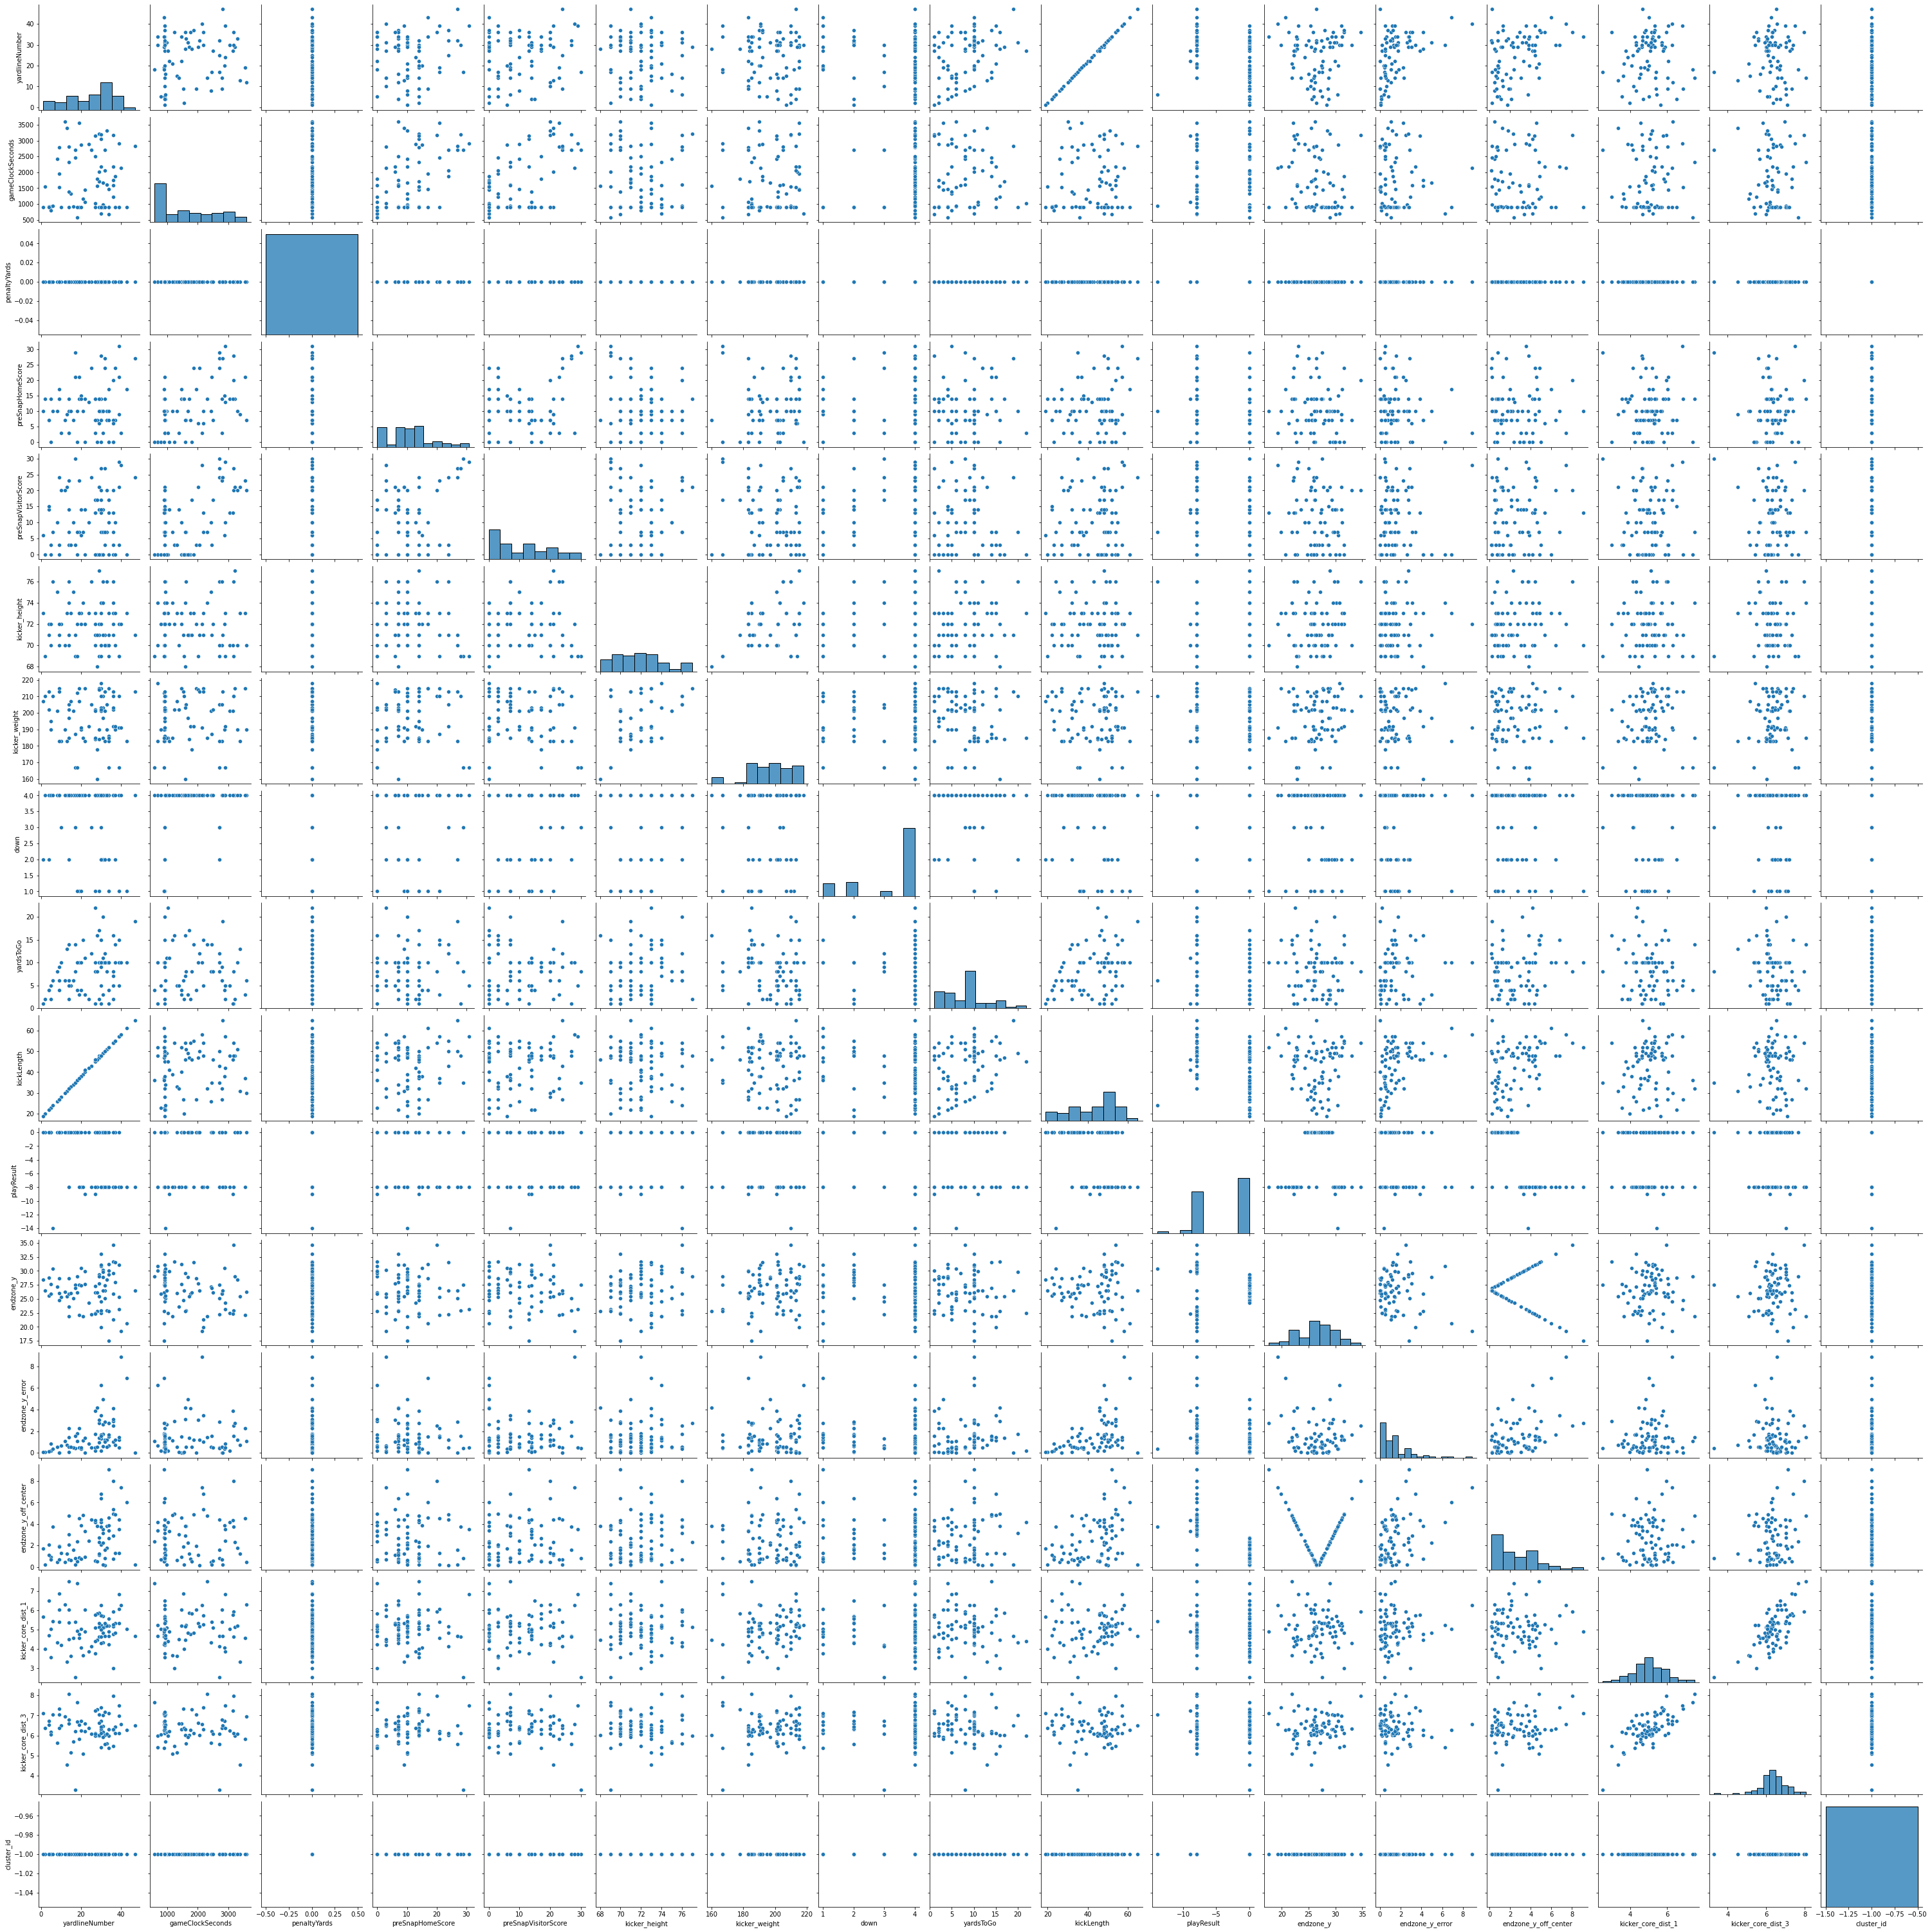

In [39]:
for id, cluster in fg_cluster_dict.items():
    plt.figure(id)
    sns.pairplot(cluster)